In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
vb = pd.read_csv("../data/vb_data_categZone.csv")
vbn = pd.read_csv("../data/vb_data_numZone.csv")
print(len(vb), 'lines loaded')

96795 lines loaded


In [3]:
X = vb.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
Xn = vbn.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
#zone_cols = [col for col in list(X.columns) if 'Start' in col or 'End' in col or 'Zone' in col]
#outcome_cols = [col for col in list(X.columns) if 'Outcome' in col]

#experiment without zones
#X = X.drop(outcome_cols, axis=1)

print(len(X.columns), 'columns in categorical dataframe')
print(len(Xn.columns), 'columns in numerical dataframe')

cols = [col for col in list(X.columns) if X[col].dtype == 'object']
X = pd.get_dummies(data=X, columns = cols)
y = vb.RewardValue

cols = [col for col in list(Xn.columns) if Xn[col].dtype == 'object']
Xn = pd.get_dummies(data=Xn, columns = cols)
yn = vbn.RewardValue

print(len(X.columns), 'columns in categorical dataframe after dummies')
print(len(Xn.columns), 'columns in numerical dataframe after dummies')

73 columns in categorical dataframe
93 columns in numerical dataframe
913 columns in categorical dataframe after dummies
204 columns in numerical dataframe after dummies


In [5]:
depth = []
for i in range(300,500,50):
    print('Checking max_features =', i)
    clf = RandomForestClassifier(n_estimators=100, max_features=i, max_depth=12)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=2)
    depth.append((i,scores.mean()))
    print('Mean cross validation accuracy:', scores.mean())

Checking max_features = 300
Mean cross validation accuracy: 0.7476212614287927
Checking max_features = 350
Mean cross validation accuracy: 0.7473113280644661
Checking max_features = 400
Mean cross validation accuracy: 0.7475076191952065
Checking max_features = 450
Mean cross validation accuracy: 0.7474766258587737


In [4]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators=100, max_features=200, max_depth=13)
# Train
clf = clf.fit(X,y)
y_pred = clf.predict(X)
print("Accuracy:", metrics.accuracy_score(y, y_pred))

Accuracy: 0.7808254558603234


In [8]:
# compute probabilities
y_prob = clf.predict_proba(X)

print('Total mean probability:', np.mean(y_prob[:,0]))

print('\nHome # Receive by score:')
for score in range(5,26,5): #['Z3','Z4','Z2','Z9','Z8']:
    cond = (vb['ActionType0']=='R') & (vb['ActionOutcome0']=='#') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    y_pred = clf.predict(X[cond])
    homepoints = len(y_pred[y_pred==1])
    totalpoints = len(X[cond])
    #print(score, np.mean(y_prob[cond,1], axis=0), 0.5+0.5*np.mean(vb.RewardValue[cond], axis=0))
    print('%s: avg probability %.1f%% (actual %.1f%%), %.1f%% classified as home point ' % \
          (score, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           100*homepoints/totalpoints))
    
    
print('\nHome Set by zone:')
for zone in ['3A','3B','3C','3D','2A','2B','2C','2D','4A','4B','4C','4D','9B','9C','8B','8C','7B','7C']:
    cond = (vb['ActionType0']=='E') & (vb['ActionHome0']==1) & (vb['ActionStartZone0']=='Z'+zone)
    y_pred = clf.predict(X[cond])
    homepoints = len(y_pred[y_pred==1])
    totalpoints = len(X[cond])
    #print(score, np.mean(y_prob[cond,1], axis=0), 0.5+0.5*np.mean(vb.RewardValue[cond], axis=0))
    print('%s: avg probability %.1f%% (actual %.1f%% out of %d), %.1f%% classified as home point ' % \
          (zone, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           len(y_pred), 100*homepoints/totalpoints))    

print('\nPlayers average point probability (as home only):')
for name in ['Jordan Deshane','Ben Hooker','Matt Neaves','Danny Aspenlieder','Coltyn Liu']:
    cond = (vb['PlayerName']==name) & (vb['ActionHome0']==1)
    print('%s: %.1f%% (actual %.1f%%)' % (name, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0)))
    
print('\nAway Attack:')
for outcome in ['=','/','-','!','+','#']:
    cond = (vb['ActionType0']=='A') & (vb['ActionAway0']==1) & (vb['ActionOutcome0']==outcome)
    y_pred = clf.predict(X[cond])
    awaypoints = len(y_pred[y_pred==-1])
    totalpoints = len(X[cond])
    print('%s: avg probability %.1f%% (actual %.1f%%), %.1f%% classified as away point ' % \
          (outcome, 100*np.mean(y_prob[cond,0], axis=0), 50-50*np.mean(vb.RewardValue[cond], axis=0),\
           100*awaypoints/totalpoints))

Total mean probability: 0.4811775748740616

Home # Receive by score:
5: avg probability 70.6% (actual 69.7%), 100.0% classified as home point 
10: avg probability 70.8% (actual 71.5%), 100.0% classified as home point 
15: avg probability 70.8% (actual 69.9%), 100.0% classified as home point 
20: avg probability 71.5% (actual 73.5%), 100.0% classified as home point 
25: avg probability 71.3% (actual 71.3%), 100.0% classified as home point 

Home Set by zone:
3A: avg probability 65.9% (actual 65.5% out of 1093), 99.8% classified as home point 
3B: avg probability 70.2% (actual 71.3% out of 1378), 99.9% classified as home point 
3C: avg probability 67.5% (actual 68.8% out of 494), 100.0% classified as home point 
3D: avg probability 65.0% (actual 61.3% out of 429), 99.8% classified as home point 
2A: avg probability 64.4% (actual 63.8% out of 152), 100.0% classified as home point 
2B: avg probability 62.9% (actual 57.6% out of 99), 98.0% classified as home point 
2C: avg probability 69.8%

### Feature importance

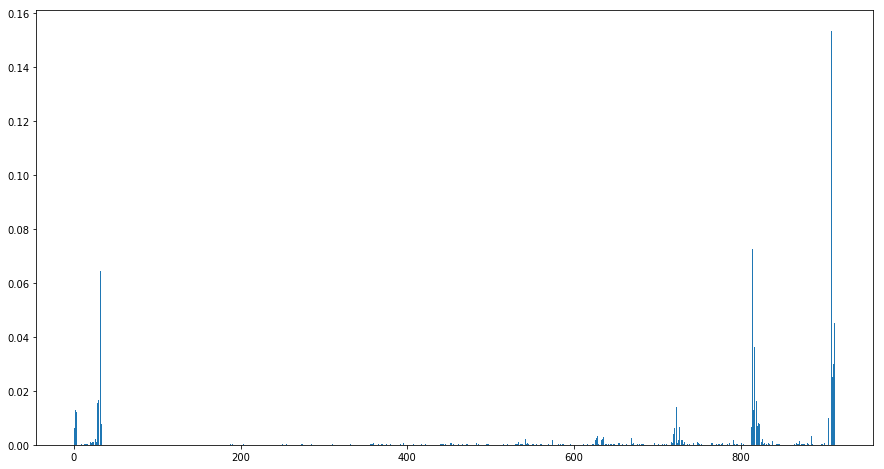

1 ActionOutcome0_# 0.15
2 ActionOutcome0_= 0.12
3 ActionOutcome1_# 0.07
4 ActionAway0 0.06
5 ActionHome0 0.06
6 ActionOutcome0_/ 0.04
7 ActionOutcome1_/ 0.04
8 ActionOutcome1_- 0.04
9 ActionOutcome0_- 0.03
10 ActionOutcome0_+ 0.03
11 ActionAway1 0.02
12 ActionType0_A 0.02
13 ActionHome1 0.02
14 ActionType1_A 0.01
15 ActionOutcome0_! 0.01
16 ScoreMax 0.01
17 ActionOutcome1_+ 0.01
18 ScoreDiff 0.01
19 ActionEndZone0_Z= 0.01
20 ActionType0_D 0.01
21 ActionType0_E 0.01
22 ActionSpeed0 0.01
23 ActionType0_B 0.01
24 ActionType1_E 0.01
25 ActionOutcome1_! 0.01


In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.bar(range(1,914),clf.feature_importances_)
plt.show()

indxs = clf.feature_importances_.argsort()[-25:][::-1]
for i in range(1,len(indxs)+1):
    idx = indxs[i-1]
    print('%d %s %.2f' % (i, X.columns[idx], clf.feature_importances_[idx]))